# Credit Default Risk


In [ ]:
%pip install vectice -U

In [41]:
import vectice
vectice.__version__

'24.2.1.0'

## Imports


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import vectice
from vectice import autolog

connect = autolog.config(
  api_token = "",
  phase = "PHA-4600"
)


Welcome, bdaversa. You`re now successfully connected to Vectice.
Phase 'Model Monitoring' successfully retrieved.

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-4600

Autolog is continuously evolving to enhance supported libraries, environments, and functionalities to provide an improved user experience.
For detailed information, supported libraries and environments please consult the documentation: https://api-docs.vectice.com/reference/vectice/autolog/


## Upload Monitoring Data and Training Data for Drift Analysis

In [31]:
from sklearn.model_selection import train_test_split
import pandas as pd
# Training data
prod_data = pd.read_csv('./production_data_Q1.csv')
train_data = pd.read_csv('./training_data.csv')



In [32]:
prod_data.head()

,prod_predict_proba,target_predicted
0,0.414745,0.0
1,0.389779,0.0
2,0.000000,0.0
3,0.791371,0.0
4,1.000000,0.0


In [33]:
train_data.head()

,target,train_proba_predict
0,0.0,0.554161
1,0.0,0.789387
2,0.0,0.852442
3,0.0,0.733134
4,0.0,0.642439


In [40]:
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, ks_2samp
def cramers_v_score(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)

    # Calculate Chi-Squared statistic
    chi2 = chi2_contingency(contingency_table)[0]

    # Number of observations
    n = contingency_table.sum().sum()

    # Calculate Cramer's V score
    phi2 = chi2 / n
    r, c = contingency_table.shape
    phi2corr = max(0, phi2 - ((c - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    ccorr = c - ((c - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((ccorr - 1), (rcorr - 1)))



def ks_score(x, y):
    min_length = min(len(x), len(y), 4000)
    x = x[:min_length]
    y = y[:min_length]
    ks_statistic, _ = ks_2samp(x, y)
    return ks_statistic


def prediction_drift(
    predict_proba_train,
    predict_proba_test,
):

    train_predictions = np.array(predict_proba_train)
    test_predictions = np.array(predict_proba_test)

    light_red = "#FF8A80"  # Light Red
    darker_blue = "#1565C0"  # Darker Blue
    sns.set_palette([darker_blue, light_red])

    _, ax = plt.subplots(figsize=(8, 6))

    sns.kdeplot(train_predictions, color=light_red, label="Train Predictions", fill=True)
    sns.kdeplot(test_predictions, color=darker_blue, label="Test Predictions", fill=True)

    # Plot vertical lines for means using the specified colors
    ax.axvline(np.mean(train_predictions), color=light_red, linestyle="--", label="Train Mean")
    ax.axvline(np.mean(test_predictions), color=darker_blue, linestyle="--", label="Test Mean")

    plt.xlabel("Predictions")
    plt.ylabel("Density")
    plt.title("Prediction Drift Plot (Kolmogorov-Smirnov drift score)")
    plt.legend()
    plt.grid(True)
    path = "Prediction_drift.png"

    # Calculate and print drift score
    drift_score = ks_score(train_predictions, test_predictions)

    # Set text position at the top
    text_x = 0.5
    text_y = 0.95
    if drift_score < 0.1:
        score_color = "green"
    elif 0.1 <= drift_score <= 0.2:
        score_color = "orange"
    else:
        score_color = "red"

    plt.text(
        text_x,
        text_y,
        f"Drift score = {drift_score:.2f}",
        ha="center",
        va="top",
        color=score_color,
        transform=ax.transAxes,
    )

    plt.savefig(path)
    plt.show()

    plt.close()

    return drift_score

def label_drift(
    train_label,
    prod_label,
):

    train_labels = np.array(train_label)
    test_labels = np.array(prod_label)

    light_red = "#FF8A80"  # Light Red
    darker_blue = "#1565C0"  # Darker Blue
    sns.set_palette([darker_blue, light_red])

    _, ax = plt.subplots(figsize=(8, 6))

    bar_width = 0.35
    index = np.arange(2)

    train_counts = [np.sum(train_labels == 0) / len(train_labels), np.sum(train_labels == 1) / len(train_labels)]
    test_counts = [np.sum(test_labels == 0) / len(test_labels), np.sum(test_labels == 1) / len(test_labels)]

    train_bar = ax.bar(index, train_counts, bar_width, label="Train Labels")
    test_bar = ax.bar(index + bar_width, test_counts, bar_width, label="Test Labels")

    ax.set_xlabel("Labels")
    ax.set_ylabel("Frequency")
    ax.set_title("Label Drift Plot (Cramer's V drift score)")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(["0", "1"])
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar in *bars*, displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(train_bar)
    autolabel(test_bar)

    drift_score = cramers_v_score(train_labels, test_labels)
    if drift_score < 0.1:
        score_color = "green"
    elif 0.1 <= drift_score <= 0.2:
        score_color = "orange"
    else:
        score_color = "red"

    ax.text(0.5, 0.95, f"Drift score = {drift_score:.3f}", ha="center", va="top", color=score_color, transform=ax.transAxes)

    plt.tight_layout()
    path = "Label_drift.png"
    plt.savefig(path, bbox_inches= "tight")
    plt.show()
    plt.close()


    return drift_score

Error in callback <function start_listen.<locals>._capture_graph at 0x1778195e0> (for pre_execute):


SyntaxError: invalid syntax (<unknown>, line 1)

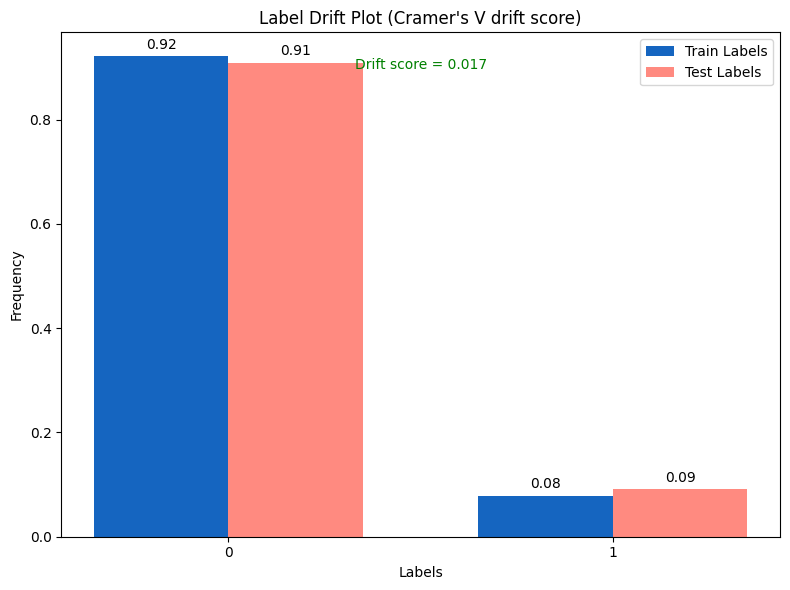

In [35]:
cramer_drift = label_drift(train_data["target"], prod_data["target_predicted"],
)


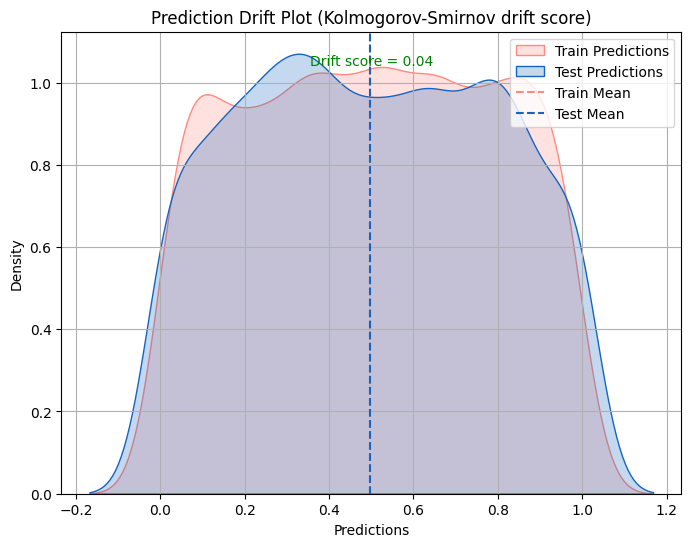

In [36]:
ks_drift = prediction_drift(train_data["train_proba_predict"], prod_data["prod_predict_proba"])

In [18]:
autolog.notebook(capture_schema_only=False)

New Iteration 'Iteration 2' created.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-9764
File: ./production_data_Q1.csv wrapped successfully.
Dataset 'PHA-4600-prod_data' logged in iteration 'Iteration 2'.
File: ./training_data.csv wrapped successfully.
Dataset 'PHA-4600-train_data' logged in iteration 'Iteration 2'.
Graph 'Prediction_drift.png' logged in iteration 'Iteration 2'.


In [22]:
model = autolog.get_connection().browse(asset="MDV-6301")
iteration = autolog.get_connection().browse("ITR-9764")

iteration.log("Label_drift.png")
iteration.log(model)

Existing model version: 'MDV-6301' of model: 'Probability of default' linked to iteration: 'Iteration 2'.
Link to iteration: https://app.vectice.com/browse/iteration/ITR-9764



# Refresh with Q2 Data

In [28]:
autolog.phase_config("PHA-4650")

Phase 'Model monitoring Q2' successfully retrieved.

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-4650


In [29]:
prod_data = pd.read_csv('./production_data_Q2.csv')
train_data = pd.read_csv('./training_data.csv')
autolog.cell(capture_schema_only=False)

Iteration 'Iteration 1' successfully retrieved.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-9765
File: ./production_data_Q2.csv wrapped successfully.
Dataset 'PHA-4650-prod_data' logged in iteration 'Iteration 1'.
File: ./training_data.csv wrapped successfully.
Dataset 'PHA-4650-train_data' logged in iteration 'Iteration 1'.


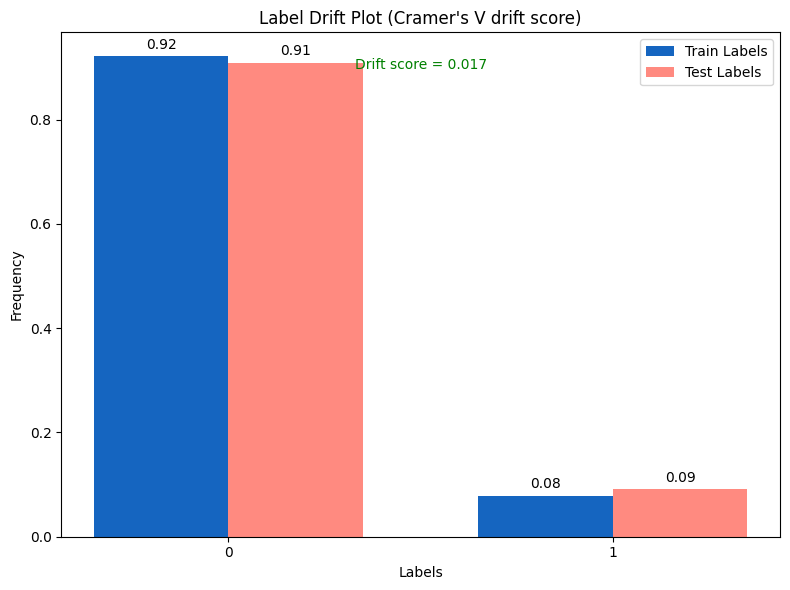

In [25]:
cramer_drift = label_drift(train_data["target"], prod_data["target_predicted"],
)

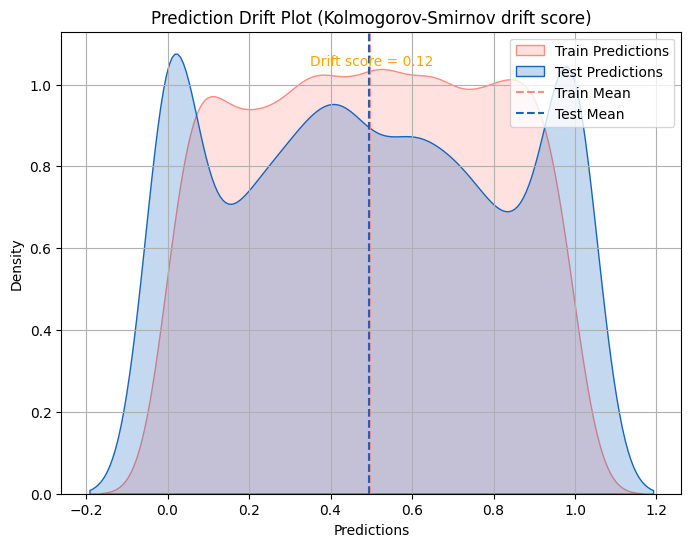

In [26]:
ks_drift = prediction_drift(train_data["train_proba_predict"], prod_data["prod_predict_proba"])

In [27]:
model = autolog.get_connection().browse(asset="MDV-6301")
model.update(properties={"Label_drift_Q2":cramer_drift,"Prediction_drift_Q2":ks_drift})


Model version 'Version 8' successfully retrieved.

For quick access to the Model version in the Vectice web app, visit:
https://app.vectice.com/browse/modelversion/MDV-6301
Model version 'MDV-6301' properties successfully updated.


In [30]:
iteration = autolog.get_connection().browse("ITR-9765")
iteration.log(model)
iteration.log("Label_drift.png")
iteration.log("Prediction_drift.png")


Iteration number 1 successfully retrieved.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-9765
Existing model version: 'MDV-6301' of model: 'Probability of default' linked to iteration: 'Iteration 1'.
Link to iteration: https://app.vectice.com/browse/iteration/ITR-9765

Added image: 'Label_drift.png' to iteration: 'Iteration 1'.
Link to iteration: https://app.vectice.com/browse/iteration/ITR-9765

Added image: 'Prediction_drift.png' to iteration: 'Iteration 1'.
Link to iteration: https://app.vectice.com/browse/iteration/ITR-9765

